In [ ]:
## ***Uncertainty Quantification***

Exercise 1 

Prof. Dr. Martin Frank
#### **EXERCISE SHEET 1**

In [1]:
import numpy as np
import sobol_seq
from pyDOE import *
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.stats import norm

&nbsp;

**EXERCISE 1)**

Execute the following four sections:


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   a) In this section we compare different sequences to approximate the value of  π. What does the code do exactly?

In [2]:
def generateSamples (N):
  samples=np.empty((N,2,5))
  labels=list()
  # MC
  samples[:,:,0]=np.random.uniform(0,1,(N,2))
  labels.append('Monte Carlo')

  # Latin hypercube
  samples[:,:,1]=lhs(2,samples=N,criterion="c")
  labels.append('Latin Hyp')

  # Halton Set
  halton_sample = tfp.mcmc.sample_halton_sequence(2, N,randomized=True, seed=127)
  samples[:,:,2] = halton_sample.numpy()
  labels.append('Halton')

  # Sobol Set
  samples[:,:,3]=sobol_seq.i4_sobol_generate(2, N)
  labels.append('Sobol')

  # Additive Recurrence
  alphax=np.random.uniform(0,1,(1,1))
  alphay=np.random.uniform(0,1,(1,1))
  x=np.cumsum(np.ones((N,1))*alphax)%1
  y=np.cumsum(np.ones((N,1))*alphay)%1
  samples[:,0,4]=x
  samples[:,1,4]=y
  labels.append('Additive rec')

  return [samples,labels]


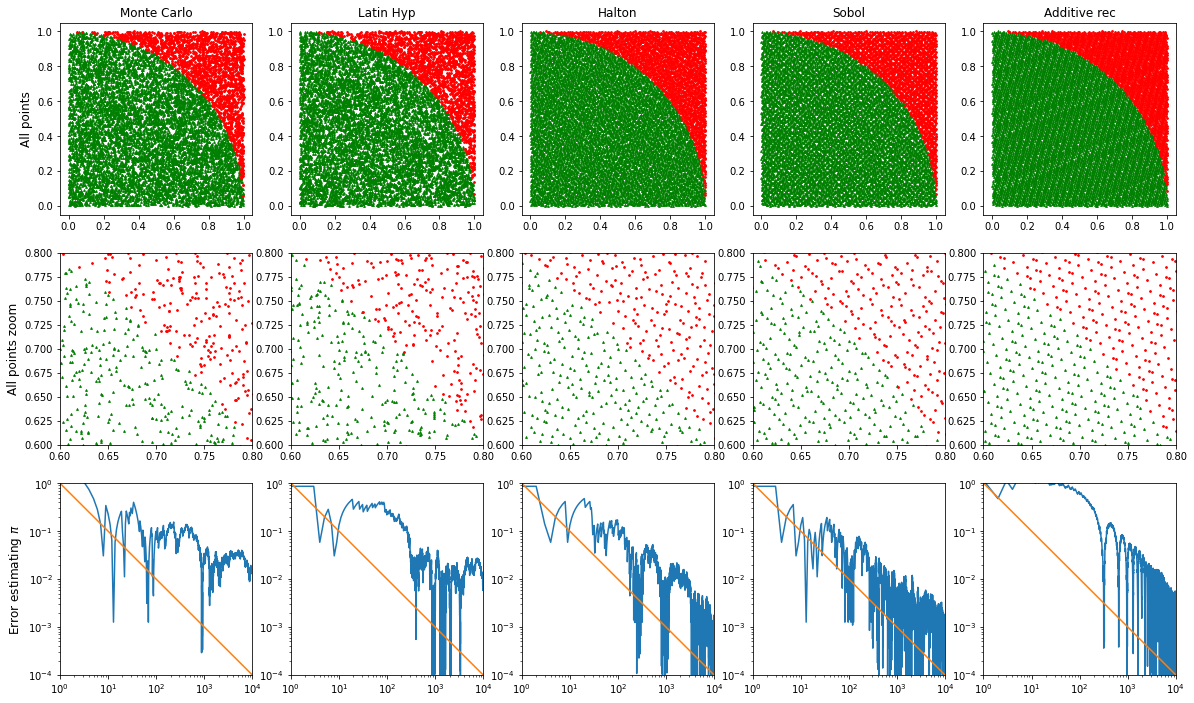

In [13]:
#Numbers of samples 
N=10000

#Generate samples
[samples,labels]=generateSamples(N)

K= np.size(samples,2)

#Check whether samples fall into unit circle
inside=np.empty((N,K),dtype=bool)

for k in range(K):
  inside[:,k]=(samples[:,0,k]**2+samples[:,1,k]**2 <1)

#Plot results
fig, ax = plt.subplots(3,K,figsize=(4*K, 12))

for k in range(K):

  #label axes
  ax[0,k].set_title(labels[k])
  if k==0:
    ax[0,k].set_ylabel('All points', rotation=90, size='large')
    ax[1,k].set_ylabel('All points zoom', rotation=90, size='large')
    ax[2,k].set_ylabel('Error estimating $\pi$', rotation=90, size='large')
    
  #Scatter samples and color according to position (in/outside circle)
  ax[0,k].scatter(samples[inside[:,k],0,k], samples[inside[:,k],1,k], c='green',s=3,marker='^')
  ax[0,k].scatter(samples[~inside[:,k],0,k], samples[~inside[:,k],1,k], s=3,c='red')

  #Show zoomed region (point structure)
  ax[1,k].scatter(samples[inside[:,k],0,k], samples[inside[:,k],1,k], c='green',s=3,marker='^')
  ax[1,k].scatter(samples[~inside[:,k],0,k], samples[~inside[:,k],1,k], s=3,c='red')
  ax[1,k].set_xlim([0.6, 0.8])
  ax[1,k].set_ylim([0.6, 0.8])

  #Show error convergence
  xmean=np.divide(np.cumsum(inside[:,k]),range(1,N+1))
  ax[2,k].loglog(abs(math.pi-4*xmean))
  ax[2,k].loglog(range(1,N+1),np.divide(1,range(1,N+1)))
  ax[2,k].set_xlim([10**0, N])
  ax[2,k].set_ylim([1/N, 1])

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   b) What are we computing here? What happens if the number of batches tends towards infinity. How can you interpret the observations?

In [14]:
def giveError(N):

  #Generate samples
  [samples,labels]=generateSamples(N)
  K= np.size(samples,2)f

  #Check whether samples fall into unit circle
  inside=np.empty((N,K),dtype=bool)
  error=np.empty((N,5))

  for k in range(K):
    inside[:,k]=(samples[:,0,k]**2+samples[:,1,k]**2 <1)
    
    #Compute error
    xmean=np.divide(np.cumsum(inside[:,k]),range(1,N+1))
    error[:,k]= abs(math.pi-4*xmean)

  return error, labels

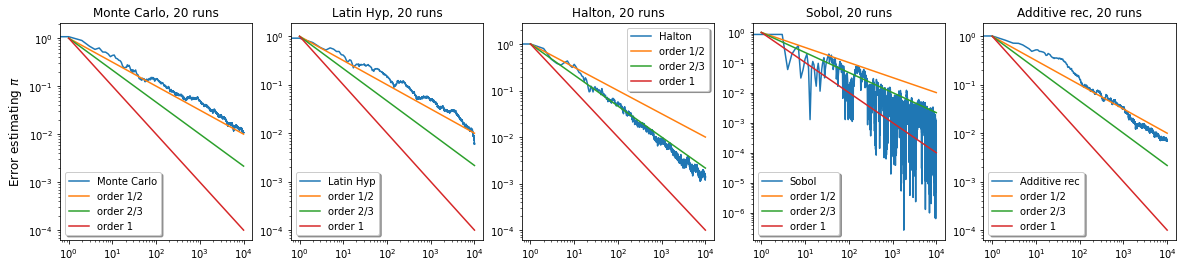

In [15]:
#Number of samples per batch
nSamples=10000

#Number of batches
nBatches=20

for i in range(nBatches):
  #print("Batch {0} of {1}".format(i+1,nBatches))
  if i==0:
    [err , labels] = giveError(nSamples)
  else:
    err=err + giveError(nSamples)[0]

err = np.divide(err, nBatches)

#Plot results
fig, ax = plt.subplots(1,K,figsize=(4*K, 4))
for k in range(K):

  #label axes 
  ax[k].set_title("{0}, {1} runs".format(labels[k], nBatches))

  if k==0:
    ax[k].set_ylabel('Error estimating $\pi$', rotation=90, size='large')

  ax[k].loglog(err[:,k],label=labels[k])
  ax[k].loglog(range(1,nSamples+1),np.divide(1,np.sqrt(range(1,nSamples+1))),label='order 1/2')
  ax[k].loglog(range(1,nSamples+1),np.divide(1,np.arange(1,nSamples+1)**(2/3)),label='order 2/3')
  ax[k].loglog(range(1,nSamples+1),np.divide(1,range(1,nSamples+1)),label='order 1')

  #label curves
  ax[k].legend(shadow=True, fancybox=True)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   c) Interpret the graph created by c) and comment on random numbers vs. quasi random numbers (or Monte-Carlo vs. Quasi-Monte-Carlo).

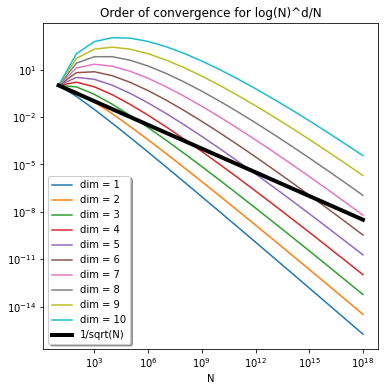

In [6]:
#Compute and plot log(N)^d/N for different values of N and d
toNormalize=True

N=10**np.arange(1,19)

plt.figure(figsize=(6,6))
for d in range(1,11):
  err=np.divide(np.log(N)**d,N)
  if toNormalize:
    err = np.divide(err,err[0])
  plt.loglog(N, err,label="dim = {0}".format(d))

err = np.divide(1,np.sqrt(N))

if toNormalize:
  err = np.divide(err, err[0])

plt.loglog(N,err,label="1/sqrt(N)", c="black",linewidth=4)
plt.title("Order of convergence for log(N)^d/N")
plt.xlabel("N")
_ = plt.legend(shadow=True, fancybox=True,loc='lower left')

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   d) It is often said, that Monte-Carlo does not suffer from the Curse of dimensionality.          
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   How does this statement and the observations from d) fit together?

&nbsp; 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   *Note: Don't worry if the graph doesn't appear immediately, computation can take a minute*

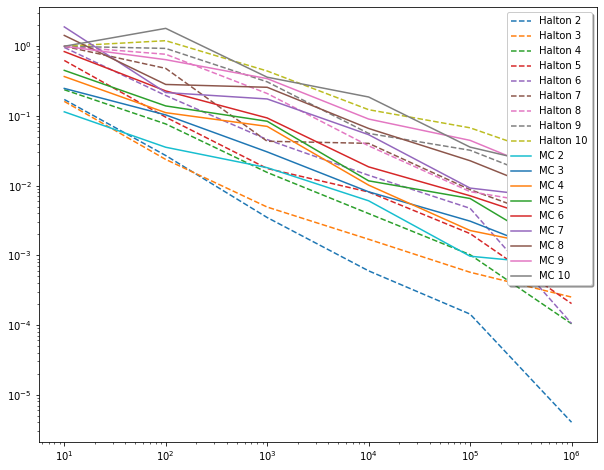

In [7]:
def volb1(dim):
  return math.pi**(dim/2)/math.gamma(dim/2 + 1)

volb= np.vectorize(volb1)

def volc(dim):
  return 2**dim
  
#Halton set

dim = 10
nSamples = 10**np.arange(1,7)
nBatches = 10
error = np.empty((np.size(nSamples),dim))

sample = tfp.mcmc.sample_halton_sequence(dim, num_results=nSamples[np.size(nSamples)-1],randomized=True, seed=127)
sample= sample.numpy()

for batch in range(1,nBatches+1):
  #print("Batch {0} of {1}".format(i+1,nBatches))

  for i in range(np.size(nSamples)):
    n=nSamples[i]
    inside = np.empty((n,dim),dtype=bool)
    r=np.random.randint(0,nSamples[np.size(nSamples)-1]-n+1)
    p=sample[r:r+n-1,:]
    # sequencer=ghalton.Halton(dim)
    # p= sequencer.get(10)
    # p=np.random.shuffle(p)
    s= 2*np.subtract(p,0.5)
    s=np.cumsum(s**2,1)
    inside = sum(s <= 1)
    volbmc = np.multiply(np.divide(inside,n),volc(np.arange(1,dim+1)))
    error [i,:]= np.divide(np.absolute(volbmc - volb(np.arange(1,dim+1))),volb(np.arange(1,dim+1)))
    

  if batch==1:
    Error=error
  else:
    Error= Error + error

Error = np.divide(Error,nBatches)

plt.figure(figsize=(10,8))
for d in range(1,dim):
  plt.loglog(nSamples, Error[:,d], label="Halton {0}".format(d+1),linestyle='dashed')


 #Uniform random numbers

for batch in range(1,nBatches+1):
  #print("Batch {0} of {1}".format(i+1,nBatches))
  i=0
  for n in nSamples:
    inside = np.empty((n,dim),dtype=bool)
    p=np.random.uniform(0,1,(n,dim))
    s= 2*np.subtract(p,0.5)
    s=np.cumsum(s**2,1)
    inside = sum(s <= 1)
    volbmc = np.multiply(np.divide(inside,n),volc(np.arange(1,dim+1)))
    error [i,:]= np.divide(np.absolute(volbmc - volb(np.arange(1,dim+1))),volb(np.arange(1,dim+1)))
    i = i+1

  if batch==1:
    Error=error
  else:
    Error= Error + error

Error = np.divide(Error,nBatches)


for d in range(1,dim):
  plt.loglog(nSamples, Error[:,d], label="MC {0}".format(d+1))

_ = plt.legend(shadow=True, fancybox=True,loc='upper right')

&nbsp;

### **Additional Exercises**



&nbsp;

**EXERCISE 5)**

Use the Chebyshev's Lemma to prove the Weak Law of Large Numbers.

&nbsp;

*Chebyshev's Lemma:* 

Let $X$ be a random variable with mean $\mu$ and variance $\sigma^2$. Then for any real number $r$ we have 
&nbsp;

$$ P(| X - \mu | \geq r\sigma) \leq \frac{1}{r^2}.$$

&nbsp;

*The Weak Law of Large Numbers:*

Let $X_1,X_2,...$ be an infinite sequence of iid random variables with finite mean $E(X_1) = E(X_2) = ... = \mu$ and finite variance $Var(X_1) = Var(X_2) = ... = \sigma^2$, and define the sequence of means 
&nbsp;

$$ \bar X_n = \frac{1}{n}(X_1 + ... + X_n).$$
&nbsp;

Show that, as $n \rightarrow \infty$, $\bar X_n$ converges to $\mu$ in probability, i.e. for every $\epsilon > 0$

&nbsp;

$$ \lim_{n \to \infty} P(|\bar X_n -\mu | \geq \epsilon) = 0.$$

&nbsp;

**EXERCISE 6)**

Consider the random ODE

$$ \frac{du}{dt}(t,Z) = \alpha(Z) u(t,Z), \;\;\; u(0,Z) = \beta(Z).$$

Assume that $\alpha$ is uniformly distributed on the interval $[a,b]$, and that $\beta$ is Gaussian normal distributed.

&nbsp;

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  (a) Compute the expected value and the variance of $u(t,Z)$ at a fixed time $t$.

&nbsp;

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  (b) Use Python to approximate the expectation value of $u(t,Z)$ by Monte-Carlo sampling.         

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  How does the approximation behave with the sample size?

&nbsp;

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  (c) Approximate also the standard deviation of $u(t,Z)$.